# Explainable reasoning with ChiRho (categorical variables)


The **Explainable Reasoning with ChiRho** package aims to provide a systematic, unified approach to causal explanation computations in terms of different probabilistic queries over expanded causal models that are constructed from a single generic program transformation applied to an arbitrary causal model represented as a ChiRho program. The approach of reducing causal queries to probabilistic computations on transformed causal models is the foundational idea behind all of ChiRho. The key strategy underlying "causal explanation" queries is their use of auxiliary variables representing uncertainty about which interventions or preemptions to apply, implicitly inducing a search space over counterfactuals.

The goal of this notebook is to illustrate how the package can be used to provide approximate method of answering a range of causal explanation queries with respect to models in which categorical variables play the key role.

In [another notebook](https://basisresearch.github.io/chirho/actual_causality.html) we illustrate how the module allows for a faithful reconstruction of a particular notion of local explanation (the so-called Halpern-Pearl modified definition of actual causality [(J. Halpern, MIT Press, 2016)](https://mitpress.mit.edu/9780262537131/actual-causality/)), which inspired some of the conceptual steps underlying the current implementation.

**Outline**

[Introduction and motivations](#intuitions-and-motivations)
    
- [The but-for condition](#the-but-for-condtition)

- [Witness nodes and context sensitivity](#witness-nodes-and-context-sensitivity)

[Simplified actual causality](#simplified-actual-causality)

[Probability of causation](#probability-of-causation)

[Causal explanation](#causal-explanation)

In [1]:
import os

import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
import torch

import networkx as nx
import matplotlib.pyplot as plt

import pandas as pd

import seaborn as sns

from chirho.observational.handlers import condition
from chirho.counterfactual.handlers.counterfactual import MultiWorldCounterfactual
from chirho.explainable.handlers import SearchForExplanation
                                            
from chirho.indexed.ops import (IndexSet, gather, indices_of) 
from chirho.interventional.handlers import do


smoke_test = ('CI' in os.environ)
runs_n = 5 if smoke_test else 8000

## Introduction and motivations

Let's start with a very simple model, in which a forest fire can be caused by exactly one of two things: a match being dropped (`match_dropped`), or a lightning strike (`lightning`), and either of these factors alone is already deterministcally sufficient for the `forest_fire` to occur. In general, you think a match being dropped is more likely than a lightning strike (we use fairly large probabilities for the sake of example transparency). 

In [2]:
def ff_disjunctive():
        match_dropped = pyro.sample("match_dropped", dist.Bernoulli(0.7)) # notice uneven probs here
        lightning = pyro.sample("lightning", dist.Bernoulli(0.4))

        forest_fire = pyro.deterministic("forest_fire", torch.max(match_dropped, lightning), event_dim=0)

        return {"match_dropped": match_dropped, "lightning": lightning,
            "forest_fire": forest_fire}

# each run is stochastic
ff_disjunctive()

{'match_dropped': tensor(0.),
 'lightning': tensor(1.),
 'forest_fire': tensor(1.)}

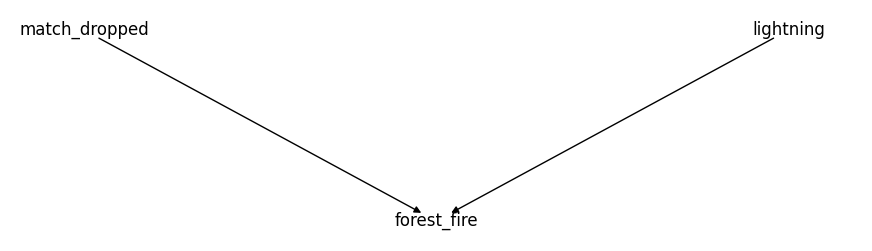

In [3]:
# this is just a plot
G = nx.DiGraph()
nodes = ["match_dropped", "lightning", "forest_fire"]
G.add_nodes_from(nodes)
G.add_edges_from([("match_dropped", "forest_fire"), ("lightning", "forest_fire")])

pos = {
    "match_dropped": (0, 0),
    "lightning": (1, 0),
    "forest_fire": (0.5, -1)
    }
plt.figure(figsize=(11, 3)) 
nx.draw_networkx(G, pos = pos, arrows = True,
    node_shape = 's', node_color = 'white',
    arrowsize = 10)
plt.axis('off')
plt.show()

# nx used as pyro graph rendering doesn't handle deterministic nodes

Suppose in this particular case you know a forest fire has occured, a match has been dropped, but no lightning occured. This further assumption can be introduced by conditioning on these observations:

In [4]:
observations = {"match_dropped": torch.tensor(1.), 
                "lightning": torch.tensor(0.),
                "forest_fire": torch.tensor(1.)}

with condition(data = observations):
    with pyro.poutine.trace() as tr:
        ff_disjunctive()

print({key: tr.trace.nodes[key]["value"] for key in tr.trace.nodes.keys()})


{'match_dropped': tensor(1.), 'lightning': tensor(0.), 'forest_fire': tensor(1.)}


In a particular context like this, if you know what happened, or at least know the values of some of the variables at play, you might be interested in using the model to answer **a range of causal-explanation related questions**.

- Did the dropped match actually cause the fire?
- Suppose you only know that the forest fire occurred, what are the likely explanations? How likely are they?
- Suppose you know both factors occurred, to what extent should they be deemed responsible for this outcome?

Let's see how these can be addressed using ChiRho. 

### The but-for condition

The initial intuition that you might have is that in this situation, `match_dropped` is a cause of `forest_fire`, because had the match not been dropped, the forest fire would not have occurred, or, in other words, there would be no forest fire but for the match being dropped. The `Search for Explanation` handler can be used to test for this condition, and returns the expected result in this case.

In [5]:
pyro.set_rng_seed(101)

# you can manually specify 
# the alternative value(s) of the antecedent(s)
# for a contrastive comparison
antecedents = {"match_dropped": 0.0} 


witnesses = {} # ignore witnesses for now

consequents = {"forest_fire": constraints.boolean}
# you need to specify the outcome distro
# in general there's a separate handler that provides 
# some assistance, we'll illustrate its use later


with MultiWorldCounterfactual() as mwc:  # needed to keep track of multiple scenarios
    with SearchForExplanation(antecedents = antecedents, 
                              witnesses = witnesses,
                              consequents = consequents,
                              consequent_scale= 1e-8):
        with condition(data = observations):
            with pyro.plate("sample", 10): # run a few times
                with pyro.poutine.trace() as tr:
                    ff_disjunctive()

print(tr.trace.nodes.keys())

odict_keys(['__antecedent_match_dropped', 'match_dropped', 'lightning', 'forest_fire_factual', 'forest_fire_counterfactual', '__consequent_forest_fire', 'forest_fire'])


Intuitively, we used `SearchForExplanation` to investigate what would have happened to the consequent(s) if we intervened on the antecedent(s) as specified, and we ran the model a few times as the run now contains stochastic elements. The trace now contains more information.

1.  We have randomly intervened (for now, with uniform Bernoulli distribution) on `match_dropped` as specified in `antecedents`. `__antecedent_match_dropped` now contains information about whether a given intervention has been preempted (that is, it has value `0` if the intervention wasn't blocked in a given run, and 1 if the intervention was blocked). 

In [6]:
nd = (tr.trace.nodes)
print("__antecedent_match_dropped:", nd["__antecedent_match_dropped"]["value"])

__antecedent_match_dropped: tensor([1, 0, 0, 0, 1, 0, 1, 1, 1, 1])


At this point you might think that randomly preempting the intervention from happening is an unnecessary complication, and in this particular case it in fact is. However, the functionality is generally useful for searching through multiple antecedent sets. For this simple example we could suppress this by shifting the uniform preemption probability down by .5, to 0.

In [7]:
pyro.set_rng_seed(100)

with MultiWorldCounterfactual() as mwc:  
    with SearchForExplanation(antecedents = antecedents,
                              # lower the probability of antecedent preemption 
                              # from .5 (default) to .4 
                              witnesses = witnesses, 
                              consequents = consequents,
                              # this is a scale for scoring changes to the consequent
                              consequent_scale= 1e-8):
        with condition(data = observations):
            with pyro.plate("sample", 10): 
                with pyro.poutine.trace() as tr:
                    ff_disjunctive()

tr.trace.compute_log_prob()
nd = (tr.trace.nodes)

print("__antecedent_match_dropped:", nd["__antecedent_match_dropped"]["value"])

__antecedent_match_dropped: tensor([1, 0, 1, 0, 0, 1, 0, 0, 0, 1])


2. `match_dropped` and `forest_fire` now contain values for the factual and the counterfactual scenarios:

In [8]:
with mwc: # use the same mwc context
    # each potential upstream intervention extends the indices
    print( indices_of(nd["match_dropped"]["value"]))
    # you can use the indices to pick the right values with gather
    antecedent_factual = gather(nd["match_dropped"]["value"], IndexSet(**{'match_dropped': {0}}))
    antecedent_counterfactual = gather(nd["match_dropped"]["value"], IndexSet(**{'match_dropped': {1}}))

    consequent_factual = gather(nd["forest_fire"]["value"], IndexSet(**{'match_dropped': {0}}))
    consequent_counterfactual = gather(nd["forest_fire"]["value"], IndexSet(**{'match_dropped': {1}}))


print("Antecedent Factual:\n", antecedent_factual)
print("Antecedent Counterfactual:\n", antecedent_counterfactual)
print("Consequent Factual:\n", consequent_factual)
print("Consequent Counterfactual:\n", consequent_counterfactual)

IndexSet({'match_dropped': {0, 1}})
Antecedent Factual:
 tensor([[[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]]]])
Antecedent Counterfactual:
 tensor([[[[[1., 0., 1., 0., 0., 1., 0., 0., 0., 1.]]]]])
Consequent Factual:
 tensor([[[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]]]])
Consequent Counterfactual:
 tensor([[[[[1., 0., 1., 0., 0., 1., 0., 0., 0., 1.]]]]])


3. While we already see that here the answer is positive, the counterfactual value of the consequent would be different, to handle more general cases, `__consequent_forest_fire` records the score assigned to whether the factual and counterfactual values of the consequent differ as a value in the log prob space. We used `consequent_scale= 1e-8` which in the binary case results in `log_prob = 0` for cases in which there is a difference and in `-inf` for cases where there isn't.

In [9]:
with mwc: 
    print(gather(nd['__consequent_forest_fire']['log_prob'], 
                IndexSet(**{'match_dropped': {1}})))

tensor([[[[[-inf, 0., -inf, 0., 0., -inf, 0., 0., 0., -inf]]]]])


One problem with the but-for analysis of causality, however, is that it misdiagnoses causal factors in cases that involve over-determination. For example, if we ask the same question in the context in which both a match has been dropped and a lightning strike occurred, the answer will be negative, as strictly speaking preventing the match from being dropped wouldn't have prevented the forest fire. Similarly, the lightning would not have been taken to be a cause either. This is a misdiagnosis, as we still think that these factors played a causal role.


In [10]:
pyro.set_rng_seed(99)

observations = {"match_dropped": torch.tensor(1.),
                "lightning": torch.tensor(1.),  # we changed this line 
                "forest_fire": torch.tensor(1.)}

with MultiWorldCounterfactual() as mwc:  
    with SearchForExplanation(antecedents = antecedents, 
                              witnesses = witnesses, 
                              consequents = consequents,
                              consequent_scale= 1e-8):
        with condition(data = observations):
            with pyro.plate("sample", 10):
                with pyro.poutine.trace() as tr:
                    ff_disjunctive()

tr.trace.compute_log_prob()
nd = tr.trace.nodes
with mwc: 
    print(gather(nd['__consequent_forest_fire']['log_prob'], 
                IndexSet(**{'match_dropped': {1}})))
    
# -inf indicates no change to the consequent!

tensor([[[[[-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf]]]]])


### Witness nodes and context sensitivity

Some of these intuitions in the forest fire example may be salvaged by considering a two-membered antecedent set:

In [11]:
antecedents = {"match_dropped": 0.0, 'lightning': 0.0}

with MultiWorldCounterfactual() as mwc:  
    with SearchForExplanation(antecedents = antecedents,
                              # we ca enforce the execution of the intervention
                              # if we're not realy searching through
                              # cause candidates 
                              # by shifting the probability of antecedent preemption
                              # from .5 (default) to 0
                              antecedent_bias= -.5, 
                              witnesses = witnesses, 
                              consequents = consequents,
                              consequent_scale= 1e-8):
        with condition(data = observations):
            with pyro.plate("sample", 10):
                with pyro.poutine.trace() as tr:
                    ff_disjunctive()

tr.trace.compute_log_prob()
nd = tr.trace.nodes
with mwc: 
    print(gather(nd['__consequent_forest_fire']['log_prob'], 
                IndexSet(**{'match_dropped': {1}, "lightning": {1}})))  
                # note we needed to add the index for lightning now
    
# 0s indicate change to the consequent

tensor([[[[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]]]]])


This already suggests a more complicated picture, as it turns out that we need to pay attention to membership in larger antecedent sets that would make a difference (that is one reason why we need stochasticity in antecedent candidate preemption: to search for such sets).

But even then, the but-for analysis does not pay sufficient attention to the granularity of a given problem and its causal structure. There are asymmetric cases where the efficiency of one cause prevents the efficiency of another, in which our causal attributions should also be asymmetric, but "being a member of the same larger antecedent set" isn't.

A simple example is breaking a bottle. Suppose Sally and Bob throw a rock at a bottle, and Sally does so a little earlier than Bob. Suppose both are perfectly accurate, and the bottle shatters when hit. Sally hits, the bottle 
shatters, but Bob doesn't hit it because the bottle is no longer there.  

Sally's throw does not satisfy the but-for condition: if she hadn't thrown the rock, the bottle would still have shattered. Of course, the combined event of Sally throwing a rock and Bob throwing a rock is a but-for cause of the bottle shattering. But that doesn't capture the clear asymmetry at work here. Intuitively, Sally's throw is the (actual) cause of the bottle breaking in a way that Bob's throw isn't.  Sally's throw actually caused the bottle to shatter and Bob's throw didn't, in part because Bob's stone didn't actually hit the bottle.

An intuitive solution to the problem, inspired by the  Pearl-Halpern definition of actual causality (which we discuss in [another notebook](https://basisresearch.github.io/chirho/actual_causality.html)) is to say that **in answering actual causality queries, we need to consider what happens when part of the actual context is kept fixed.** For instance, in the bottle shattering example, given the observed fact that Bob’s stone didn’t hit, in the counterfactual world in which we keep this observed fact fixed, if Sally did not throw the stone, the bottle in fact would not have shattered. 

For this reason, `SearchForCauses` allows not only stochastic preemption of interventions (to approximate the search through possible antecedent sets), but also stochastic witness preemption of those nodes that are considered part of the context (these needn't exclude each other). In a witness preemption, we ensure that the counterfactual value is identical to the factual one (and by applying it randomly to candidate witness nodes, we approximate a search through all possible context sets). Let's define the model and apply the handler before looking at what the trace now contains.

In [12]:
def stones_model():        
    prob_sally_throws = pyro.sample("prob_sally_throws", dist.Beta(1, 1))
    prob_bill_throws = pyro.sample("prob_bill_throws", dist.Beta(1, 1))
    prob_sally_hits = pyro.sample("prob_sally_hits", dist.Beta(1, 1))
    prob_bill_hits = pyro.sample("prob_bill_hits", dist.Beta(1, 1))
    prob_bottle_shatters_if_sally = pyro.sample("prob_bottle_shatters_if_sally", dist.Beta(1, 1))
    prob_bottle_shatters_if_bill = pyro.sample("prob_bottle_shatters_if_bill", dist.Beta(1, 1))

    sally_throws = pyro.sample("sally_throws", dist.Bernoulli(prob_sally_throws))
    bill_throws = pyro.sample("bill_throws", dist.Bernoulli(prob_bill_throws))

    # if Sally throws, she hits with probability prob_sally_hits
    # hits with pr=0 otherwise
    new_shp = torch.where(sally_throws == 1,prob_sally_hits, 0.0)

    sally_hits = pyro.sample("sally_hits",dist.Bernoulli(new_shp))

    # if Bill throws, he hits with probability prob_bill_hits
    # if sally doesn't hit sooner,
    # misses otherwise
    new_bhp = torch.where(
        bill_throws.bool() & (~sally_hits.bool()),
        prob_bill_hits,
        torch.tensor(0.0),
    )

    bill_hits = pyro.sample("bill_hits", dist.Bernoulli(new_bhp))

    # you can use a analogous move to model the bottle shattering
    # if being hit by a stone doesn't deterministically
    # shatter the bottle
    new_bsp = torch.where(bill_hits.bool(), prob_bottle_shatters_if_bill,
            torch.where(sally_hits.bool(),prob_bottle_shatters_if_sally,torch.tensor(0.0),),)

    bottle_shatters = pyro.sample("bottle_shatters", dist.Bernoulli(new_bsp))

    return {"sally_throws": sally_throws, "bill_throws": bill_throws,  "sally_hits": sally_hits,
            "bill_hits": bill_hits,  "bottle_shatters": bottle_shatters,}

stones_model.nodes = ["sally_throws","bill_throws", "sally_hits", "bill_hits","bottle_shatters",]

def tensorize_observations(observations):
    return {k: torch.as_tensor(v) for k, v in observations.items()}

# for now, we assume the mechanisms are deterministic
# and that both sally and bill throw stones
observations = {"prob_sally_throws": 1.0, 
                "prob_bill_throws": 1.0,
                "prob_sally_hits": 1.0,
                "prob_bill_hits": 1.0,
                "prob_bottle_shatters_if_sally": 1.0,
                "prob_bottle_shatters_if_bill": 1.0,
                "sally_throws": 1.0, "bill_throws": 1.0}

observations_tensorized = tensorize_observations(observations)

antecedents = {"sally_hits": torch.tensor(0.)}

# this now specifies those nodes that are candidates for witnesses
# i.e. those parts of context that are held fixed in a given run
# in the counterfactual world
witnesses = {"bill_hits": constraints.boolean,}


consequents = {"bottle_shatters": constraints.boolean}

pyro.set_rng_seed(100)

with MultiWorldCounterfactual() as mwc:
    with SearchForExplanation(antecedents = antecedents, 
                       witnesses = witnesses, 
                       consequents = consequents,
                       consequent_scale= 1e-8):
        with condition(data = observations_tensorized):
            with pyro.plate("sample", 5000): 
                # increased sample size as we'll be estimating probabilities soon
                with pyro.poutine.trace() as tr:
                    stones_model()

tr.trace.compute_log_prob()

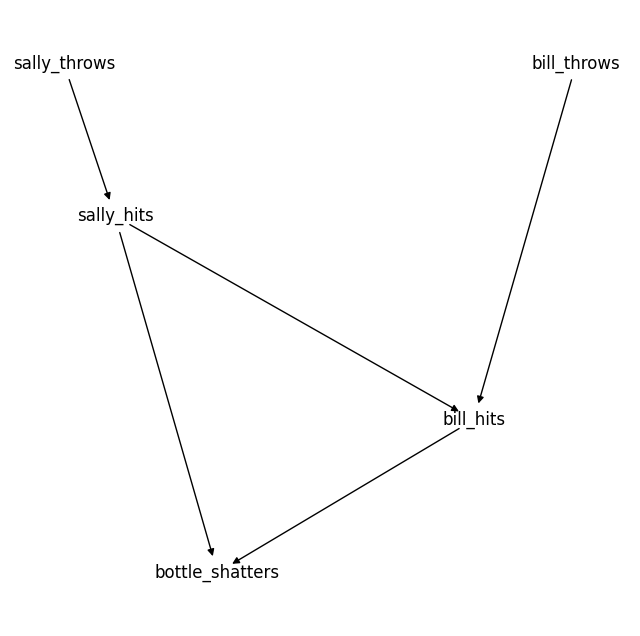

In [13]:
# the essential causal structure of our model is this
G = nx.DiGraph()
nodes = ["sally_throws","bill_throws", "sally_hits", "bill_hits","bottle_shatters",]
G.add_nodes_from(nodes)
G.add_edges_from([("sally_throws", "sally_hits"), ("bill_throws", "bill_hits"),
                  ("sally_hits", "bottle_shatters"),("sally_hits", "bill_hits"), 
                  ("bill_hits", "bottle_shatters")])

pos = {
    "sally_throws": (0, 0),
    "bill_throws": (1, 0),
    "sally_hits": (0.1, -.6),
    "bill_hits": (.8, -1.4),
    "bottle_shatters": (.3, -2) 
}

plt.figure(figsize=(8, 8)) 
nx.draw_networkx(G, pos = pos, arrows = True,
    node_shape = 's', node_color = 'white',
    arrowsize = 10)
plt.axis('off')
plt.show()

Besides the original nodes and the auxiliary `__antecedent` and `__consequent` nodes, the trace now contains also:

-  new auxiliary variables of the form `__witness_<node_name>`, which record whether in a particular model run the original node has been considered part of the context to be fixed. If so, its counterfactual value has been preempted to be the same as its factual value (witness preemption trumps antecedent intervention if the antecedent and witness sets overlap).
- new auxiliary variables of the form `__antecedent__proposal_<node_name>`, which records the proposed alternative values of the antecedent has been used in particular model runs. This is because instead of specifying the alternative antecedent value for contrast, passing a `constraint` instead, telling `SearchForCauses` to sample alternatives from an appropriate distribution. In the binary case this is not very exciting, as there is only one alternative value (we also introduced some redundancy as now some of the proposed values are identical to the factual value), but keeping track of proposals is definitely much more useful in the continuous case.

In [8]:
nd = tr.trace.nodes
print(nd.keys())

odict_keys(['__antecedent_match_dropped', 'match_dropped', 'lightning', 'forest_fire_factual', 'forest_fire_counterfactual', '__consequent_forest_fire', 'forest_fire'])


How do we use the resulting trace to answer causal queries that we were interested with?

## Simplified actual causality

One question you might be interested in is a simplified question in line with the original Halpern-Pearl definition (take a look at a separate notebook, if you're interested in the details of the original definition):

**Is there some context such that if it is kept fixed at the factual values, if the antecedent were different, so would be the consequent?**

In our case, we might want to know whether there are some nodes which kept fixed would make a context-restricted but-for clause true (intuitively: keeping the fact that bill failed fixed, if Sally didn't throw the stone, the bottle wouldn't have shattered). 

To answer this query using the trace we need to focus on cases in which the antecedent has been intervened and ask whether any of the resulting log prob scores is `0`.

In [15]:
mask = nd['__antecedent_sally_hits']['value'] == 0
with mwc:
    scores = gather(nd['__consequent_bottle_shatters']['log_prob'], 
                IndexSet(**{'sally_hits': 1})).squeeze()

print(torch.any(scores[mask] == 0))

tensor(True)


## Probability that X is a cause

We might be interested in more involved queries. For instance, in the probability of a context-sensitive but-for clause holding.

**Assuming each witness candidate is equally likely to be considered part of a context and we observed such and such outcome, what's the probability that the antecedent having a different value would lead to a different outcome?**

To answer this query, we need to also exclude cases in which the antecedent has been antecedent preempted.

In [16]:
mask_intervened = nd['__antecedent_sally_hits']['value'] == 0

print(
torch.mean((scores[mask_intervened] == 0).float())
)

tensor(0.4953)


In this particular case, since Sally is sure to hit if she throws and sure to shatter the bottle if she hits, the only stochastic part is whether we keep the only relevant witness (`bill_hits`) fixed. If we set witness bias to .0 and so the witness preemption probability to .5, the bottle shatters if an only if this witness is preempted, the bottle shatters. This somewhat degenerate example illustrates that `witness_bias` is an important parameter. The parameter specifies the "level of realism" with which one wants to consider the context to be fixed. At one extreme, if witness bias is `-.5` no attention is paid to the context and we're back at the but-for clause and probability of causality being 0. On another, witness bias is `.5` and then all witnesses are always kept fixed, which results in the most local evaluation and the probability of causality equaling 1.

## Causal explanation

Now imagine we only have partial knowledge. We know the probabilities involved (let's make them less trivial in this example), we observed the consequent (the bottle shattered), but we don't know what the cause of this event was. In such a situation, we include all nodes of interest in the list of potential causes **and** in the list of potential witnesses (as they might be witnesses for other nodes). Moreover, since we don't know what values they have, we can't really set some particular values as the alternative antecedent values for contrast, and need to sample from appropriate proposal distributions instead. Let's say we focus on stones hitting the bottle and the bottle shattering.

In [17]:
observations = {"prob_sally_throws": .6, 
                "prob_bill_throws": .4,
                "prob_sally_hits": .9,
                "prob_bill_hits": .8,
                "prob_bottle_shatters_if_sally": .9,
                "prob_bottle_shatters_if_bill": .8,
                "bottle_shatters": 1.}

observations_tensorized = tensorize_observations(observations)

antecedents = {"sally_hits": constraints.boolean, 
               "bill_hits": constraints.boolean}

witnesses = {"sally_hits": constraints.boolean, 
               "bill_hits": constraints.boolean}

# witnesses and antecedents now overlap
# if they both happen to be preempted,
# witness preemption wins and the 
# counterfactual values are identical to the factual ones

consequents = {"bottle_shatters": constraints.boolean}

pyro.set_rng_seed(100)

with MultiWorldCounterfactual() as mwc_prob:
    with SearchForExplanation(antecedents = antecedents, 
                       witnesses = witnesses, 
                       consequents = consequents,
                       consequent_scale= 1e-8):
        with condition(data = observations_tensorized):
            with pyro.plate("sample", 5000): 
                with pyro.poutine.trace() as tr_prob:
                    stones_model()

tr_prob.trace.compute_log_prob()
nd_prob = tr_prob.trace.nodes

There are at least two different queries that we might be interested in. We might want to focus on a particular variable and ask:

**With what probability would making a change to X make a difference to the consequent (assuming all witness candidates are equally likely)?**

which is analogous to the query we already covered (Probability that X is a cause), except now we do not assume we know what the factual value of X is. The use of trace, however, is pretty much the same:

In [18]:

with mwc_prob:
    print(indices_of(nd_prob['__consequent_bottle_shatters']['log_prob']))
    scores = gather(nd_prob['__consequent_bottle_shatters']['log_prob'], 
               IndexSet(**{'sally_hits': 1, 'bill_hits': 1})).squeeze()

# mind your head: index values equal to 1 
# mean we're picking from the counterfactual scenario
# but it's still possible we're dealing with preemption
# and the counterfactual value mirrors the factual one    

for ant in antecedents.keys():
    mask_intervened = nd_prob[f'__antecedent_{ant}']['value'] == 0

    # now we need to make sure it's not witness preempted either
    mask_not_witness = nd_prob[f'__antecedent_{ant}']['value'] == 0

    mask = torch.logical_and(mask_intervened, mask_not_witness)

    print(f"{ant}: {torch.mean((scores[mask] == 0).float())}")


IndexSet({'sally_hits': {0, 1}, 'bill_hits': {0, 1}})
sally_hits: 0.42266401648521423
bill_hits: 0.38750511407852173


But we also can start with focusing on those scenarios where the counterfactual value of the consequent differs from the factual one and ask about the probability that a given variable is involved:

**If a difference in outcomes results, what's the probability that a change in the value of $X$ was involved (assuming all the witness candidates...)?**

In [23]:

with mwc_prob:
    scores = gather(nd_prob['__consequent_bottle_shatters']['log_prob'], 
               IndexSet(**{'sally_hits': 1, 'bill_hits': 1})).squeeze()

# mind your head: index values equal to 1 
# mean we're picking from the counterfactual scenario
# but it's still possible we're dealing with preemption
# and the counterfactual value mirrors the factual one    

mask_outcome_diff = scores == 0 

for ant in antecedents.keys():

    mask_intervened = nd_prob[f'__antecedent_{ant}']['value'] == 0 
    mask_not_witness = nd_prob[f'__antecedent_{ant}']['value'] == 0
    mask = torch.logical_and(mask_intervened, mask_not_witness)
    print(f"{ant}: {torch.mean((mask[mask_outcome_diff]).float())}")


sally_hits: 0.5283300280570984
bill_hits: 0.4716699719429016


The fact that the pairs of values differ might be initially surprising. The first pair seems intuitive: after all, Sally throws first, and her probabilies are higher, so you'd expect her hitting to have higher "causal power". The latter calculations, though, also track a different probability, that of involvement.